# NBA Hypothesis Test 4 :: Playoff Teams and MANOVA

## Trevor Rowland :: 2-11-2025

This notebook aims to examine the differences between teams that made the NBA playoffs and teams that did not. Hypothesis tests will be conducted using MANOVA (Multivariate Analysis of Variance) to see if average team statistics of playoff teams and non-playoff teams differ significantly.

## Table of Contents

## 1. Importing Packages and Data

This notebook uses the following packages, all of which can be installed via `pip`.

- `numpy`
- `pandas`
- `scipy.stats`
- `matplotlib.pyplot`
- `seaborn`
- `missingno`
- add more as needed...

In [2]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msgo

The data used for this hypothesis test will be game-level and team-level NBA data from 2004-2024. The game data is used to determine which teams made the playoffs, and the team data contains the aggregated statistics for each season that will be compared via MANOVA.

In [3]:
# Set paths to data (CHANGE ON YOUR MACHINE!)
team_data = '/Users/dB/Documents/repos/github/bint-capstone/data-sources/nba/nba_team_stats_2004_2024.pkl'
game_data = '/Users/dB/Documents/repos/github/bint-capstone/data-sources/nba/game-level-dataset-2004-2024-season-appended.csv'

# Read data in via pandas methods
teams = pd.read_pickle(team_data)
games = pd.read_csv(game_data)

# Ensure both files are instantiated as pandas.core.DataFrame
print(f'Team Data is type: {type(teams)}')
print(f'Game Data is type: {type(games)}')

Team Data is type: <class 'pandas.core.frame.DataFrame'>
Game Data is type: <class 'pandas.core.frame.DataFrame'>


The data and packages have been imported, now we can examine the data with `missingno` to make sure there is no missing data.

<Axes: >

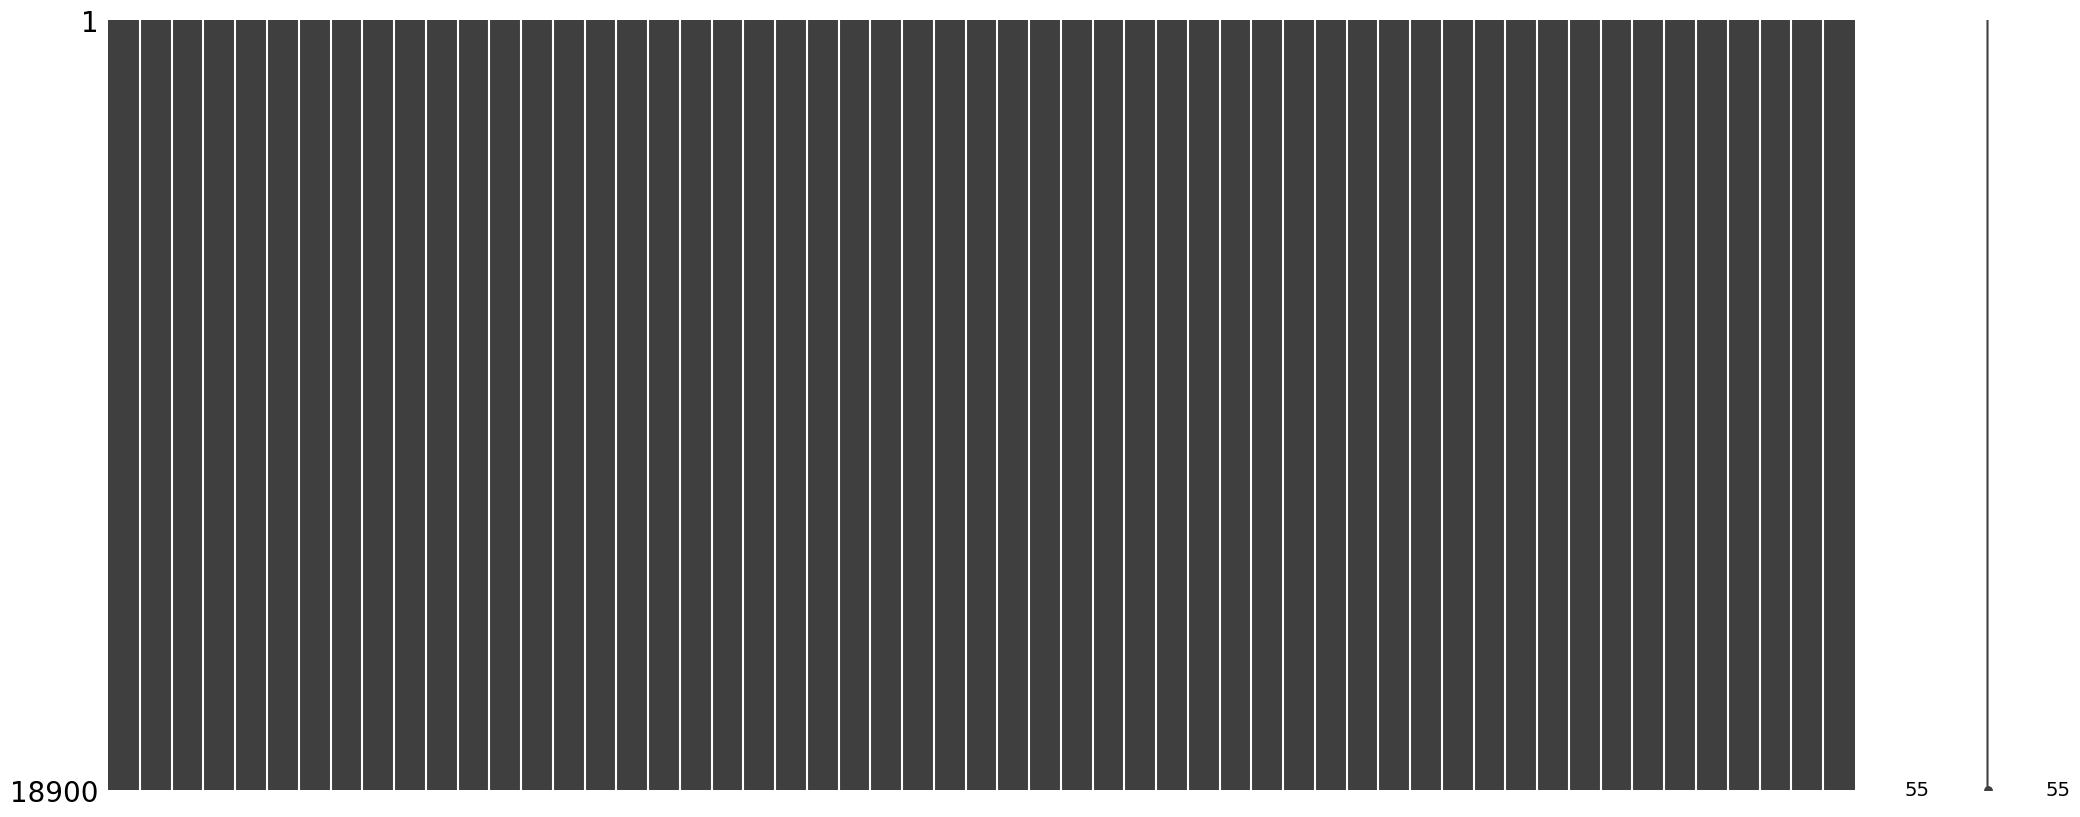

In [4]:
msgo.matrix(teams)

<Axes: >

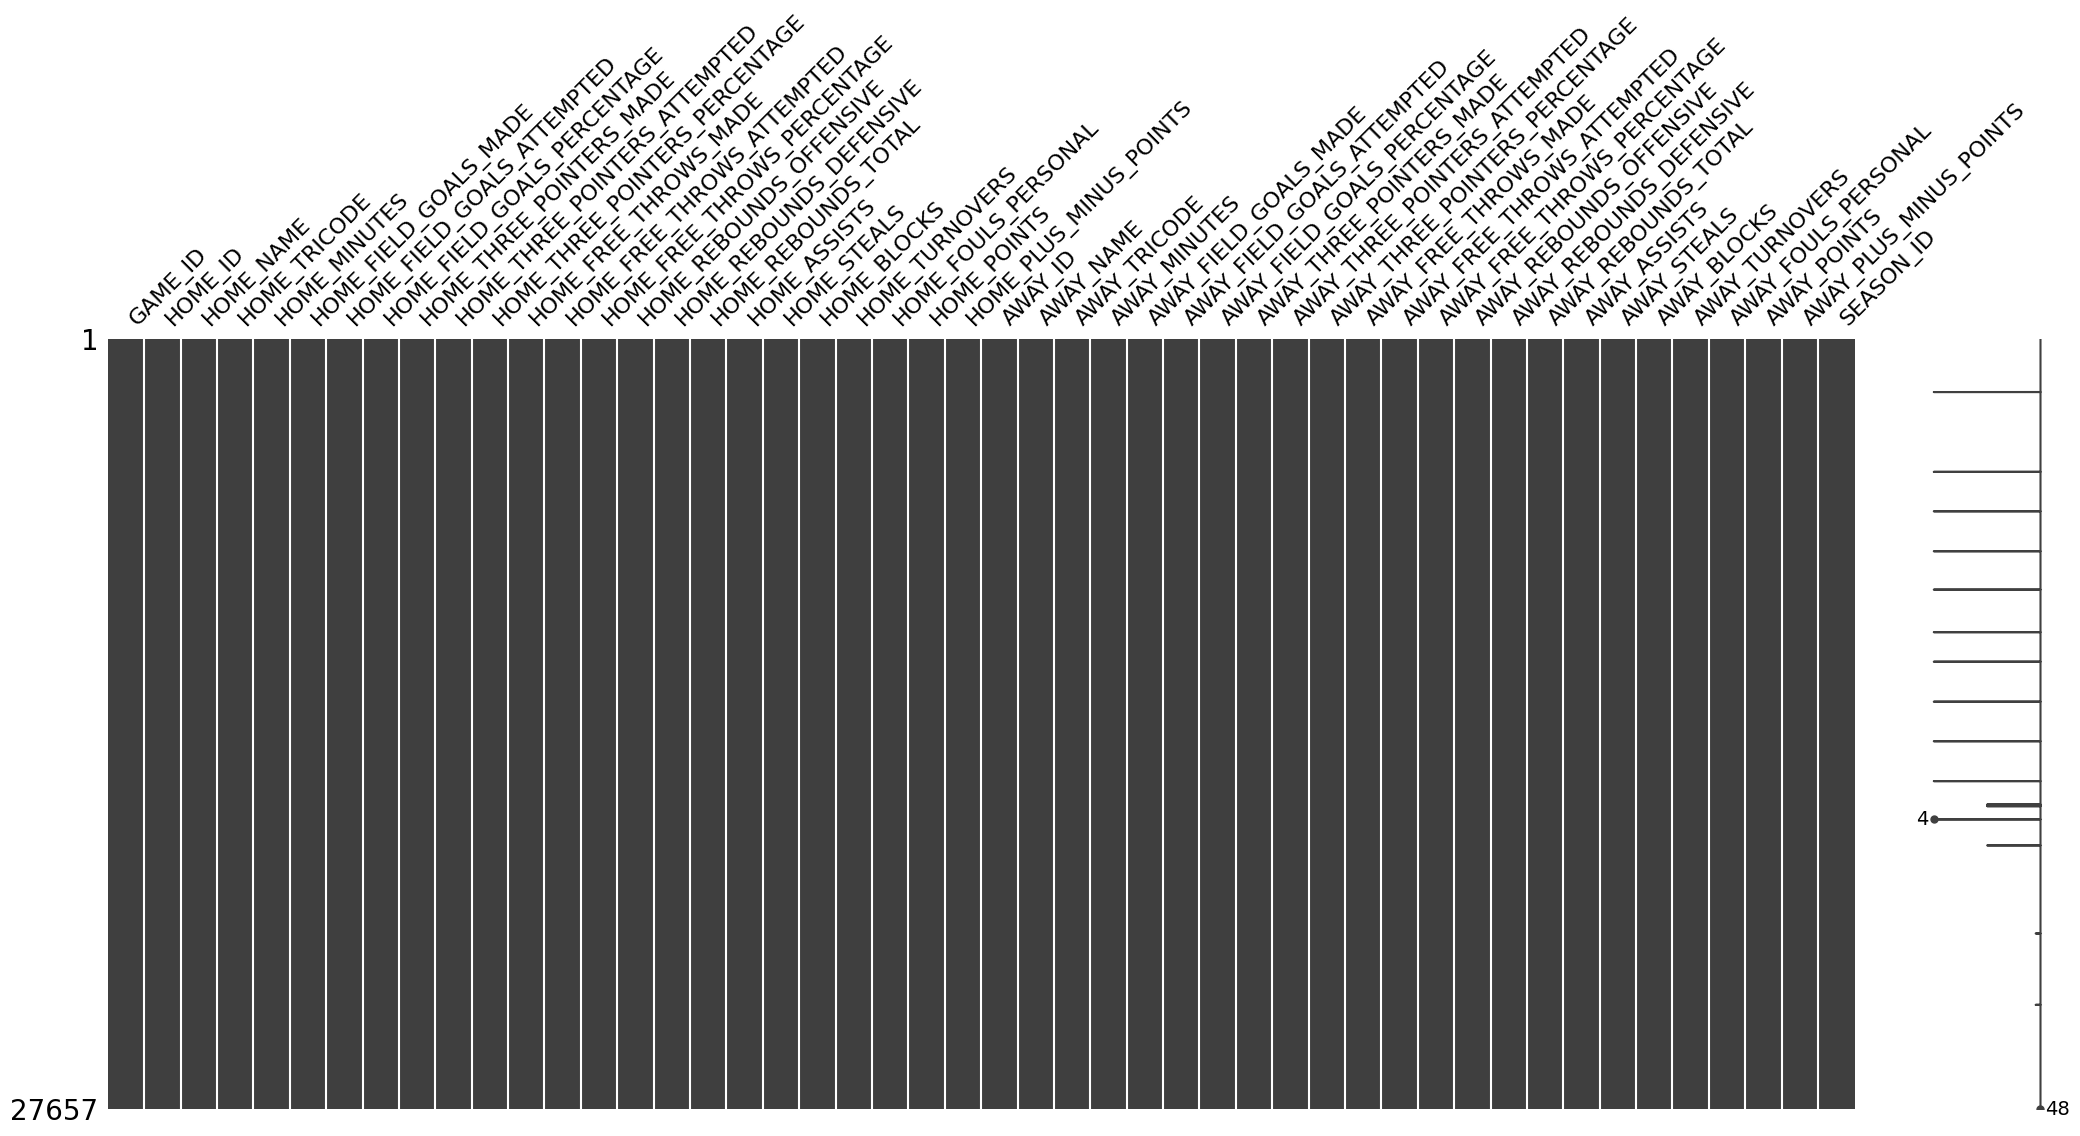

In [5]:
msgo.matrix(games)

From the `missingno.matrix` charts, we see no missing data in the `teams` data, and a very low frequency of missing data in the `games` data. We can address this if it becomes an issue later, but for now all we need are game ID's so this should be fine.

## 2. Grouping Teams by Playoff-Making and Non-Playoff Making

To group the teams, we will be examining what teams exist in playoff games within the `games` dataset. The `games` dataset contains the feature `game_id`, which identifies a playoff game with a leading `004` or `4` in the ID. Additionally, there is a home team id, `HOME_ID` that we can match up with the team id in the `teams` dataset. The following functions will create a dataset of all teams, identifying which teams made the playoffs that season and which teams did not.

In [6]:
print(teams.columns.tolist())
print(games.columns.tolist())

['team_id', 'team_name', 'gp', 'w', 'l', 'w_pct', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka', 'pf', 'pfd', 'pts', 'plus_minus', 'gp_rank', 'w_rank', 'l_rank', 'w_pct_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'fta_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'reb_rank', 'ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'pts_rank', 'plus_minus_rank', 'season']
['GAME_ID', 'HOME_ID', 'HOME_NAME', 'HOME_TRICODE', 'HOME_MINUTES', 'HOME_FIELD_GOALS_MADE', 'HOME_FIELD_GOALS_ATTEMPTED', 'HOME_FIELD_GOALS_PERCENTAGE', 'HOME_THREE_POINTERS_MADE', 'HOME_THREE_POINTERS_ATTEMPTED', 'HOME_THREE_POINTERS_PERCENTAGE', 'HOME_FREE_THROWS_MADE', 'HOME_FREE_THROWS_ATTEMPTED', 'HOME_FREE_THROWS_PERCENTAGE', 'HOME_REBOUNDS_OFFENSIVE', 'HOME_REBOUNDS_DEFENSIVE', 'HOME_REBOUNDS_TOTAL', 'HOME_ASSISTS', 'HOME_S

From the lists of columns, the features of interest for combining the datasets are:

**Teams**

- `team_id`
- `team_name`
- `season`

**Games**

- `GAME_ID`
- `HOME_ID`
- `HOME_NAME`
- `HOME_TRICODE`
- `AWAY_ID`
- `AWAY_NAME`
- `AWAY_TRICODE`
- `SEASON_ID`

*Pseudocode*


```python
teams['madePlayoffs'] = False

for game in games:
    if teams.team_id == (games.HOME_ID OR games.AWAY_ID) AND teams.season == games.SEASON_ID:
        if game.GAME_ID.starts_with(004 OR 4):
            make team with that ID for that season have field madePlayoffs = True
        else:
            leave madePlayoffs == False
```

In [7]:
team_cols_of_interest = ['team_id', 'team_name', 'season']
game_cols_of_interest = ['GAME_ID', 'HOME_ID','AWAY_ID','SEASON_ID', 'HOME_NAME', 'AWAY_NAME']

# Create dfs of just the cols of interest
team_info = teams[team_cols_of_interest]
game_info = games[game_cols_of_interest]

game_info.head(10)

,GAME_ID,HOME_ID,AWAY_ID,SEASON_ID,HOME_NAME,AWAY_NAME
0,40400407,1610612759,1610612765,2004-05,Spurs,Pistons
1,40400406,1610612759,1610612765,2004-05,Spurs,Pistons
2,40400405,1610612765,1610612759,2004-05,Pistons,Spurs
3,40400404,1610612765,1610612759,2004-05,Pistons,Spurs
4,40400403,1610612765,1610612759,2004-05,Pistons,Spurs
5,40400402,1610612759,1610612765,2004-05,Spurs,Pistons
6,40400401,1610612759,1610612765,2004-05,Spurs,Pistons
7,40400307,1610612748,1610612765,2004-05,Heat,Pistons
8,40400306,1610612765,1610612748,2004-05,Pistons,Heat
9,40400305,1610612748,1610612765,2004-05,Heat,Pistons


In [8]:
team_info.head(10)

,team_id,team_name,season
0,1610612737,Atlanta Hawks,2004-05
1,1610612737,Boston Celtics,2004-05
2,1610612737,Charlotte Bobcats,2004-05
3,1610612737,Chicago Bulls,2004-05
4,1610612737,Cleveland Cavaliers,2004-05
5,1610612737,Dallas Mavericks,2004-05
6,1610612737,Denver Nuggets,2004-05
7,1610612737,Detroit Pistons,2004-05
8,1610612737,Golden State Warriors,2004-05
9,1610612737,Houston Rockets,2004-05


Everything below needs to be redone. Keep the stuff in the detour to fix the team_id's in `teams`, and then use the SAC method 

### Quick Detour

It looks like there is an issue with the `teams` data. The `team_id` was not assigned correctly to teams. This means we will need to fix that here as well

⠀⠀⢀⣀⣄⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⠾⠛⠛⠷⣦⡀⠀⠀⠀⠀⠀⠀
⢠⣶⠛⠋⠉⡙⢷⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⣿⠐⡡⢂⠢⠈⠻⣦⡀⠀⠀⠀⠀
⣾⠃⠠⡀⠥⡐⡙⣧⣰⣤⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⡹⡜⢄⠣⢤⣩⣦⣸⣧⠀⠀⠀⠀
⣿⡀⢢⠑⠢⣵⡿⠛⠉⠉⠉⣷⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⣜⢬⣿⠛⠉⠉⠉⠻⣧⡀⠀⠀
⣹⣇⠢⣉⣾⡏⠀⠠⠀⢆⠡⣘⣷⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⡾⠟⠋⢉⠛⢷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⣿⡆⠱⡈⠔⠠⠄⠈⢷⡄⠀
⠀⢿⣦⢡⣿⠀⠌⡐⠩⡄⢊⢵⣇⣠⣀⣀⡀⠀⠀⠀⠀⣼⠟⢁⢀⠂⠆⡌⢢⢿⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⡀⠀⠀⠀⠀⣾⣅⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢻⡏⢷⡣⠜⣈⠆⡡⠂⠌⣷⠀
⠀⠀⢹⡞⣧⠈⡆⢡⠃⣼⣾⡟⠛⠉⠉⠉⠛⣷⡄⠀⢸⡏⠐⢨⡄⡍⠒⣬⢡⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣴⡟⠁⠀⠀⠀⠀⠑⢻⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⣴⣾⡖⣶⣦⠀⠀⠀⠀⠀⠀⠀⢸⡏⡜⣷⢱⢨⡆⢱⠈⡆⣿⠀
⠀⠀⠀⠽⣇⠎⡰⣩⡼⡟⠁⠄⡀⠠⠀⠀⠀⠈⢿⡄⡿⢄⢃⠖⡰⣉⠖⣡⡿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣷⡿⠁⣀⣠⣀⣤⣤⣤⣼⣿⣷⣦⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣰⢯⠋⡀⢀⠀⠉⢿⣆⠀⠀⠀⠀⠀⣸⢗⢡⣿⣂⣖⣨⡱⢊⡔⣿⠀
⠀⠀⠀⠀⣯⠒⠥⡾⢇⠰⡉⠔⡠⠃⡌⢐⠡⠀⣼⡟⡓⢌⢒⢪⠑⣌⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣴⣿⣿⣿⣻⠭⠿⠛⠒⠓⠚⠛⠛⠿⣿⣿⣿⣿⣳⡶⢦⣄⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⡚⠤⣁⠢⠐⣀⠀⣿⡀⠀⠀⠀⢈⡟⣸⢟⠉⠁⠀⠉⠙⢷⣴⠇⠀
⠀⠀⠀⠀⢿⣩⢲⣟⢌⡒⡱⢊⠴⢡⢘⣄⣢⣽⠞⡑⢌⠂⢎⠤⢋⡞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣠⣶⣿⣿⣿⠿⠋⡀⢀⠠⠀⠄⠠⠂⠄⠄⡠⠀⠄⡈⠉⠛⠛⠛⡙⠺⣭⡗⣦⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢿⣰⠂⡅⢣⠐⡠⢽⡇⠀⠀⢀⡾⡅⣯⢄⠊⠤⢁⠂⠄⠀⠙⣧⡀
⠀⠀⠀⠀⠺⣇⢾⢭⢢⠱⣡⠋⣔⣷⠋⡍⠰⢀⠊⠰⢈⠜⡠⢊⣽⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⡶⣿⡿⠛⠛⡉⡁⢄⠂⡔⢠⠂⡅⢊⢡⠘⡐⢌⣠⡑⠢⢐⠡⢊⠔⡡⢂⠅⣂⠙⡳⣎⡟⣶⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣯⠰⢃⡜⢠⢺⡇⠀⢰⡾⠅⠃⢿⣜⠌⡒⢄⢊⡐⡁⢂⠘⣧
⠀⠀⠀⠀⠀⢻⣺⡇⢎⡱⢄⡓⣾⠄⢣⠈⠅⡂⠡⠑⡈⢢⠑⢢⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⡾⣫⠗⡅⣢⣥⣧⢽⠶⠟⣶⢶⣿⠆⡜⡐⠦⠱⢌⠢⡜⢏⣿⠛⣛⠳⢾⣤⡣⡜⣠⠓⡤⢩⢳⡎⡝⡷⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡟⡰⢈⠆⡹⣇⣰⠿⡀⢌⠒⠤⠙⢷⣼⡠⢆⡔⢡⠂⠔⣻
⠀⠀⠀⠀⠀⠐⢻⣏⠦⣑⢊⠔⣿⠈⢆⡑⠂⡌⢠⠑⡈⠤⡉⢼⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣴⢻⢣⠞⣣⢵⣾⡿⢋⠃⢆⠬⣹⠗⡬⡑⢎⠴⣉⠎⣕⢪⡑⢎⠲⡸⢯⣅⡚⠤⡘⡙⠿⣶⣍⡒⠧⢎⠼⣑⢣⢏⢷⣆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡿⡐⠥⠚⡄⡙⠓⠤⡑⢌⡘⠤⡉⣼⢌⣷⠢⠜⢢⠉⢆⣿
⠀⠀⠀⠀⠀⠀⠐⣯⣚⠤⡋⡜⢫⠩⢄⠢⡑⡠⢃⠰⡁⢆⠱⣈⡧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⣾⠏⣎⢣⣾⣿⡋⢍⡰⢌⡚⣌⣾⢋⠳⡰⣉⢎⠲⣡⠚⡤⠣⡜⣌⢣⠱⣩⠙⠷⣧⠵⡨⠜⡨⠻⣿⣇⠮⣑⢎⢣⠞⣬⡙⣯⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⢻⡌⡱⢃⡜⣨⡕⢢⠑⣢⠘⢤⣹⢏⡜⣠⢣⠙⢦⡙⢦⠇
⠀⠀⠀⠀⠀⠀⠀⠽⣎⠖⡱⢌⠥⢊⠖⠓⠒⠿⣮⡔⡡⢎⠰⢂⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣼⡛⣆⡛⣴⣿⡟⠰⣌⠲⡌⢶⢞⡋⢦⡉⠖⣑⣢⣮⣵⣶⣷⣶⣷⣶⣶⣥⣧⣢⡙⢢⡑⢎⡡⡙⠴⣛⠛⡦⢓⢬⠚⣌⡓⢦⡹⢜⡻⣆⠀⠀⠀⠀⠀⠀⠀⠀⢰⣿⢜⡢⢱⣡⡿⠛⠛⢒⠳⢤⢋⠴⣛⠣⡔⢢⢎⡙⢦⣱⠟⠀
⠀⠀⠀⠀⠀⠀⠀⠀⢻⣝⡰⣉⠖⣡⠚⣈⠁⠄⠈⢻⣶⡨⢡⢃⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡾⢳⠍⣦⠱⣊⠏⡽⣉⢆⠳⢌⠣⢆⡙⣤⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣼⡠⢃⠝⡢⢅⠫⡔⡍⢦⠹⢤⡙⢦⠱⣋⡜⡻⣆⠀⠀⠀⠀⠀⠀⠀⠈⢻⣜⠲⣱⣿⠀⠂⡍⠰⣈⠦⡉⢖⡡⢓⡌⢣⠎⣜⣶⠏⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠠⢻⣖⡡⠞⣄⠓⡄⠣⢐⠀⠀⢻⣿⣥⡾⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡾⣍⢧⢫⠔⡫⠴⣉⠖⡡⢎⡱⢊⡱⣼⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣎⡑⢎⡱⡘⡜⢢⠝⣢⡙⣌⢳⡑⢮⠱⣹⣆⠀⠀⠀⠀⠀⠀⠀⠈⢿⡱⣿⣿⠀⢃⠌⡱⢠⢒⡉⢦⡑⢣⡜⢣⣾⠞⠁⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣼⠱⣌⠓⡬⠑⡌⠠⠁⢸⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⢑⠎⡖⣩⢎⡱⢣⠜⡬⡑⢎⠔⣣⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣮⡢⡑⡜⢌⡱⢪⠔⡱⢊⢦⠹⣌⠏⣄⢻⡆⠀⠀⠀⠀⠀⠀⠀⠁⠙⢿⣿⡌⡐⢌⠰⠡⢎⠜⣢⠙⣦⡽⠟⠁⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⣝⡰⢩⢌⠱⣈⣾⠏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⠇⣎⠹⡬⣑⠎⣔⠣⣍⠒⡭⢌⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡕⡘⠦⣡⢃⢎⡱⣉⢦⢋⡜⡎⢥⠊⣿⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⣔⣈⠒⣍⣢⣽⡴⠟⠉⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠙⠛⠚⠛⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡿⠐⣌⢓⠲⣉⠞⡤⢓⠬⡑⢆⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣎⢒⡡⠎⢦⠱⡌⠦⡍⠖⣭⠒⡌⢸⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠙⠛⠋⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢼⡇⢢⠙⡜⢦⢋⡴⢡⠚⡤⢓⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡌⢣⠔⡌⢦⠱⢢⠕⡲⣉⠖⣁⠚⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣾⠁⢢⠹⣌⠳⣌⠲⣡⢋⠴⣹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡐⢎⡜⢢⡙⢆⢫⠱⣌⠳⣀⠂⣿⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠠⣿⠐⢂⠳⣌⠳⣌⠳⣄⢋⣴⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡰⢌⠣⡜⣌⠣⡝⢤⠳⢄⠂⢹⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣿⠀⢣⡙⣔⠣⡜⠲⡌⢦⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢊⠵⡘⢤⡓⢬⢣⡙⠢⠌⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣿⠈⠴⡱⢌⡳⢌⠳⡘⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣎⠲⣉⠦⡙⣆⢣⠚⡅⠊⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣿⡈⡱⣘⢣⠜⡬⢣⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡰⡡⢎⡱⡌⡖⣍⠒⡡⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡇⡒⣍⠮⡜⢆⢣⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠟⡋⠍⡠⠄⡠⢀⠂⡍⢙⠻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⡑⢮⠰⡱⢜⡢⠍⢤⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣺⣇⣱⢎⢲⣉⠮⢼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢟⡋⠔⣡⠘⠤⡑⢨⠐⡁⢎⠠⢃⠌⡐⡙⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡜⣌⢣⠕⣎⡱⣩⢘⡿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠩⣷⡐⣏⠦⣃⠞⣾⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⡑⠢⠜⡰⢠⢉⠒⡌⢄⠣⡘⠄⠣⢌⠢⡑⢌⠢⡙⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣯⠔⣣⢚⡴⣑⡃⢾⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⣷⠸⣜⡰⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠋⡴⢉⠜⢢⠑⠢⢌⠒⡌⢢⠑⠤⣉⠲⡈⢆⠱⢌⠢⢡⠃⡽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢜⢢⠣⢖⡱⢌⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢻⣷⢆⡇⣻⣿⣿⣿⣿⣿⣿⣿⣿⡿⣁⠳⢨⠜⡨⢆⣉⠣⣊⠜⣈⠆⣙⡐⢢⠡⣑⢊⠒⡌⢣⢑⡊⡔⣊⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡎⡖⣹⢊⡵⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⣿⢼⡘⣽⣿⣿⣿⣿⣿⣿⣿⢏⠦⣡⢋⠲⢌⡑⠦⢌⡱⡐⠎⡤⠩⢔⠨⡅⢃⠲⢌⡱⢌⡱⢢⠱⡘⢤⣉⠻⣿⣿⣿⣿⣿⣿⣿⣿⡗⣍⠖⣯⣼⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⢺⡱⣚⣿⣿⣿⣿⣿⠟⡕⢎⠲⡡⢎⡱⢊⡜⡘⢆⠲⢡⠓⣌⠓⣌⠓⣌⢃⠳⣈⠲⢌⡒⣡⢣⡙⠦⣌⠣⡍⢿⣿⣿⣿⣿⣿⣿⡹⡰⣋⢿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⡟⡠⢇⠼⣻⠿⣟⢣⠟⡸⢜⢣⠣⡜⡠⢇⡸⢣⠜⢣⠇⡛⣄⢛⡀⢟⡀⠟⡤⢃⠻⡄⢣⢄⢣⡘⢇⡄⢧⠛⣤⢘⡿⣿⣿⣿⢟⡣⢣⠇⣿⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠚⣧⡑⡌⠒⡡⠚⢤⣳⡾⣱⠪⣅⠳⢬⠱⣊⠴⣃⠮⡑⢎⡱⢌⠦⣙⢢⡙⡜⡰⣉⠖⣩⠲⡌⢦⡙⠦⡜⢢⠛⡤⢓⡜⣆⠳⡜⢪⡑⢣⠋⣾⢁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣷⣄⣁⣠⣽⡟⢧⡱⢆⡳⣌⢓⡎⡱⣌⠳⣌⢲⣉⠖⡱⢊⠖⣡⢒⡱⣌⡱⡘⣜⢢⢓⡜⣢⡙⣜⡘⣣⢝⡸⣛⢾⣌⡳⢈⠥⠘⠠⢡⡿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠛⠋⠉⠛⢧⡝⣎⠵⣌⠧⡜⡱⣌⠳⣌⠶⡌⢞⡡⢏⠼⣡⢎⡱⢢⠵⡱⣌⢎⠦⣱⢡⠞⣤⠛⡴⢪⠵⣩⢞⣼⠿⢶⣤⣥⣤⡿⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⣽⡘⢮⡱⢳⣌⠳⣜⢢⡝⣢⢝⡸⢲⢡⠞⣰⠣⡞⡱⣌⢎⢞⡰⢣⠞⣔⡫⣜⢣⣿⠶⠋⠀⠀⠀⠈⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠓⠯⣧⣎⠳⣬⢓⡬⡱⢎⡵⣋⡬⣛⠴⣋⠶⡱⢎⡞⡬⢳⡍⣞⣦⠷⠛⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢈⡙⠓⠻⠶⠽⢮⣶⣥⣷⣭⣾⣥⣯⡵⠯⠼⠗⠛⠋⣉⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [9]:
team_info['team_id'].unique()

array([1610612737, 1610612738, 1610612739, 1610612740, 1610612741,
       1610612742, 1610612743, 1610612744, 1610612745, 1610612746,
       1610612747, 1610612748, 1610612749, 1610612750, 1610612751,
       1610612752, 1610612753, 1610612754, 1610612755, 1610612756,
       1610612757, 1610612758, 1610612759, 1610612760, 1610612761,
       1610612762, 1610612763, 1610612764, 1610612765, 1610612766])

In [10]:
team_info.loc[:, 'team_name_fixed'] = team_info['team_name'].str.split().str[-1] # Get only the last part of the string to match with the games dataset

team_info.head(10)

/var/folders/b6/zrz7f_vs0k79qphqm5sprhzr0000gn/T/ipykernel_9702/2985157182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_info.loc[:, 'team_name_fixed'] = team_info['team_name'].str.split().str[-1] # Get only the last part of the string to match with the games dataset


,team_id,team_name,season,team_name_fixed
0,1610612737,Atlanta Hawks,2004-05,Hawks
1,1610612737,Boston Celtics,2004-05,Celtics
2,1610612737,Charlotte Bobcats,2004-05,Bobcats
3,1610612737,Chicago Bulls,2004-05,Bulls
4,1610612737,Cleveland Cavaliers,2004-05,Cavaliers
5,1610612737,Dallas Mavericks,2004-05,Mavericks
6,1610612737,Denver Nuggets,2004-05,Nuggets
7,1610612737,Detroit Pistons,2004-05,Pistons
8,1610612737,Golden State Warriors,2004-05,Warriors
9,1610612737,Houston Rockets,2004-05,Rockets


Now that the team name is fixed, we can get back to work (we will fix ID's with the new, matching team names)

### Detour OVER!

Back to assigning a team a boolean on if they made the playoffs...

In [11]:
# Make a DF of just playoff games
playoff_games = games[games['GAME_ID'].astype(str).str.startswith('4')]

# Find teams that played in playoff games using their names (ids are broken for now...)
playoff_teams = set(playoff_games['HOME_NAME']).intersection(set(playoff_games['AWAY_NAME']))

# Create the 'madePlayoffs' column based on presence in playoff_teams
# team_info.loc[:,'made_playoffs'] = team_info.apply(lambda row: row['team_name_fixed'] in playoff_teams and row['season'] in , playoff_games.loc[row['SEASON_ID']].values, axis=1)

team_info.loc[:, `made_playoffs`] = team_info.apply(
    
)

team_info.head(10)

SyntaxError: invalid syntax (1233476463.py, line 10)

In [ ]:
def did_team_make_playoffs_given_season(row:pd.Series):
    global playoff_teams
    global playoff_games

    if row['team_name_fixed'] in playoff_teams:
        if row['season'] in playoff_game.loc[:,'SEASON_ID']:
            return True
        
    else:
        return False

    lambda row: row['team_name_fixed'] in playoff_teams and row['season'] in , playoff_games.loc[row['SEASON_ID']].values, axis=1

SyntaxError: invalid syntax (2699351559.py, line 12)

This is better, but we are still getting false positives (hawks didnt make the playoffs in 04-05), this still needs to be tweaked...

In [ ]:
for c in team_info.columns:
    print("---- %s ---" % c)
    print(team_info[c].value_counts())

---- team_id ---
team_id
1610612737    630
1610612738    630
1610612765    630
1610612764    630
1610612763    630
1610612762    630
1610612761    630
1610612760    630
1610612759    630
1610612758    630
1610612757    630
1610612756    630
1610612755    630
1610612754    630
1610612753    630
1610612752    630
1610612751    630
1610612750    630
1610612749    630
1610612748    630
1610612747    630
1610612746    630
1610612745    630
1610612744    630
1610612743    630
1610612742    630
1610612741    630
1610612740    630
1610612739    630
1610612766    630
Name: count, dtype: int64
---- team_name ---
team_name
Atlanta Hawks                        630
Miami Heat                           630
Utah Jazz                            630
Toronto Raptors                      630
San Antonio Spurs                    630
Sacramento Kings                     630
Portland Trail Blazers               630
Phoenix Suns                         630
Philadelphia 76ers                   630
Orlando Mag

In [ ]:
playoff_games.shape

(1675, 48)

In [ ]:
len(playoff_teams)

32

In [ ]:
print(playoff_teams)

{'Bulls', 'Bucks', 'Cavaliers', 'Thunder', 'Clippers', 'Suns', 'Jazz', 'Nuggets', 'SuperSonics', 'Pelicans', 'Knicks', 'Spurs', 'Celtics', 'Timberwolves', 'Rockets', 'Pacers', 'Magic', 'Pistons', 'Wizards', 'Nets', 'Warriors', 'Trail Blazers', 'Heat', 'Hawks', 'Lakers', 'Grizzlies', 'Mavericks', 'Hornets', 'Raptors', '76ers', 'Bobcats', 'Kings'}


## Redoing SAC Method to classify teams as playoff/non-playoff

First the games dataframe will need to be split to contain a single game id per row. We will split the dataframe up into a home game df and an away game df

In [20]:
file_id = '1YWuRcRanepm2aI2asSWj-yRL8JubY7HA'
fp = f'https://drive.google.com/uc?id={file_id}'

g = pd.read_csv(fp,encoding="utf-8")

In [21]:
g.head()

,GAME_ID,HOME_ID,HOME_NAME,HOME_TRICODE,HOME_MINUTES,HOME_FIELD_GOALS_MADE,HOME_FIELD_GOALS_ATTEMPTED,HOME_FIELD_GOALS_PERCENTAGE,HOME_THREE_POINTERS_MADE,HOME_THREE_POINTERS_ATTEMPTED,...,AWAY_REBOUNDS_DEFENSIVE,AWAY_REBOUNDS_TOTAL,AWAY_ASSISTS,AWAY_STEALS,AWAY_BLOCKS,AWAY_TURNOVERS,AWAY_FOULS_PERSONAL,AWAY_POINTS,AWAY_PLUS_MINUS_POINTS,SEASON_ID
0,40400407,1610612759,Spurs,SAS,240:00,29.0,68.0,0.426,7.0,11.0,...,26.0,34.0,17.0,8.0,6.0,6.0,24.0,74.0,-7.0,2004-05
1,40400406,1610612759,Spurs,SAS,240:00,31.0,75.0,0.413,8.0,28.0,...,27.0,40.0,19.0,6.0,8.0,5.0,21.0,95.0,9.0,2004-05
2,40400405,1610612765,Pistons,DET,265:00,37.0,84.0,0.440,2.0,9.0,...,26.0,45.0,20.0,3.0,3.0,16.0,26.0,96.0,1.0,2004-05
3,40400404,1610612765,Pistons,DET,240:00,41.0,90.0,0.456,2.0,9.0,...,32.0,44.0,15.0,1.0,9.0,17.0,21.0,71.0,-31.0,2004-05
4,40400403,1610612765,Pistons,DET,240:00,40.0,85.0,0.471,3.0,14.0,...,27.0,37.0,16.0,7.0,3.0,18.0,21.0,79.0,-17.0,2004-05
